In [1]:
# data handling
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# load
df = pd.read_csv('DailyDelhiClimateTrain.csv', index_col=0)

# check for null-entries
df.info()

# check for negative values and humidities > 100%
print('\n')
print(f'Negative meantemps: {(df['meantemp']<0).sum().astype(int) != 0}')
print(f'Negative humidity: {(df['humidity']<0).sum().astype(int) != 0}')
print(f'Humidity > 100%: {(df['humidity']>100).sum().astype(int) != 0}')
print(f'Negative wind_speed: {(df['wind_speed']<0).sum().astype(int) != 0}')
print(f'Negative meanpressure: {(df['meanpressure']<0).sum().astype(int) != 0}')


<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB


Negative meantemps: False
Negative humidity: False
Humidity > 100%: False
Negative wind_speed: False
Negative meanpressure: True


In [3]:
# air pressure cannot be negative...therefore, neither can meanpressure
df = df[df['meanpressure']>0]

/opt/anaconda3/envs/ml/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 90.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/ml/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 89.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


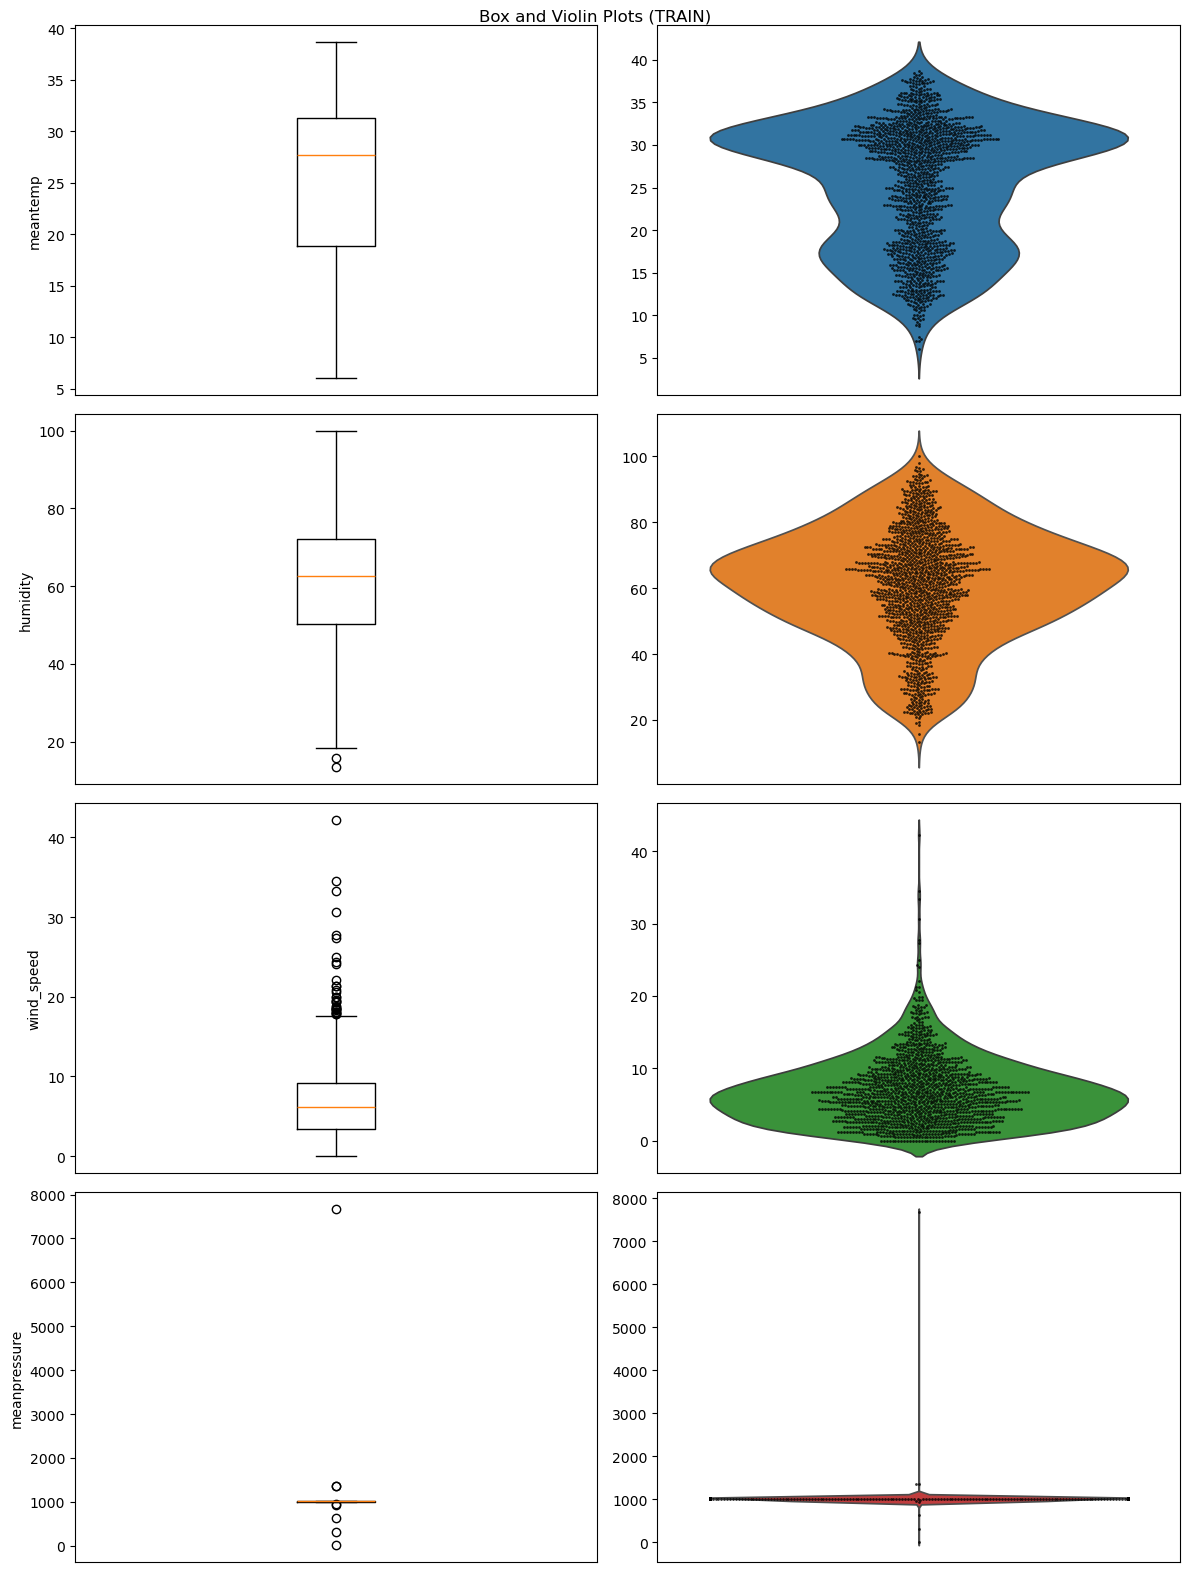

In [4]:
# check to see if data is reasonably distributed 
fig, axs = plt.subplots(4,2, figsize=(12,16))
axs[0,0].boxplot(df['meantemp'].values)
axs[0,0].set_ylabel('meantemp')
axs[0,0].set_xticks([])
sns.violinplot(x = 1, y=df['meantemp'].values, inner=None, ax=axs[0,1], color='C0')
sns.swarmplot(x= 1, y=df['meantemp'].values, color='k', alpha=0.8, size=2, ax=axs[0,1])
axs[0,1].set_xticks([])


axs[1,0].boxplot(df['humidity'].values)
axs[1,0].set_ylabel('humidity')
axs[1,0].set_xticks([])
sns.violinplot(x = 1, y=df['humidity'].values, inner=None, ax=axs[1,1], color='C1')
sns.swarmplot(x= 1, y=df['humidity'].values, color='k', alpha=0.8, size=2, ax=axs[1,1])
axs[1,1].set_xticks([])


axs[2,0].boxplot(df['wind_speed'].values)
axs[2,0].set_ylabel('wind_speed')
axs[2,0].set_xticks([])
sns.violinplot(x = 1, y=df['wind_speed'].values, inner=None, ax=axs[2,1], color='C2')
sns.swarmplot(x= 1, y=df['wind_speed'].values, color='k', alpha=0.8, size=2, ax=axs[2,1])
axs[2,1].set_xticks([])

axs[3,0].boxplot(df['meanpressure'].values)
axs[3,0].set_ylabel('meanpressure')
axs[3,0].set_xticks([])
sns.violinplot(x = 1, y=df['meanpressure'].values, inner=None, ax=axs[3,1], color='C3')
sns.swarmplot(x= 1, y=df['meanpressure'].values, color='k', alpha=0.8, size=2, ax=axs[3,1])
axs[3,1].set_xticks([])

plt.suptitle('Box and Violin Plots (TRAIN)')
plt.tight_layout()
plt.show()

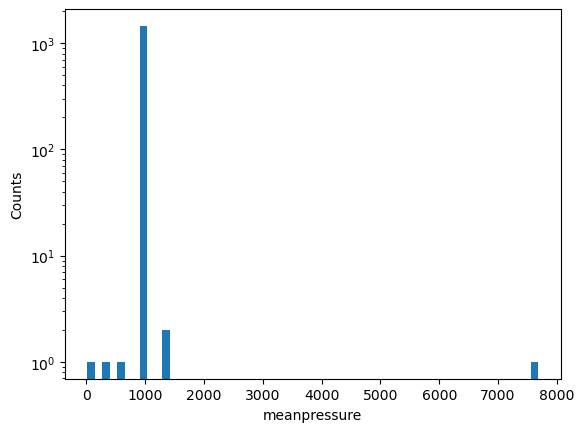

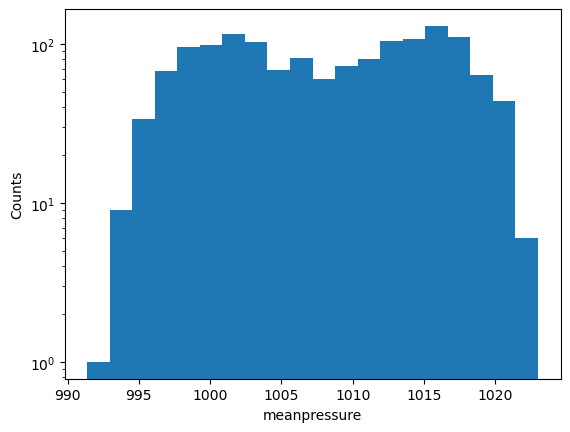

In [5]:
# there are a few unrealistic pressure measurements
plt.hist(df['meanpressure'], bins=60)
plt.ylabel('Counts')
plt.xlabel('meanpressure')
plt.yscale('log')
plt.show()

# atmospheric pressure can only vary slightly (~ few %)
# lets eliminate erroneous pressure measurents
df = df[(df['meanpressure'] > 950) & (df['meanpressure'] < 1050)]
plt.hist(df['meanpressure'], bins=20)
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('meanpressure')
plt.show()

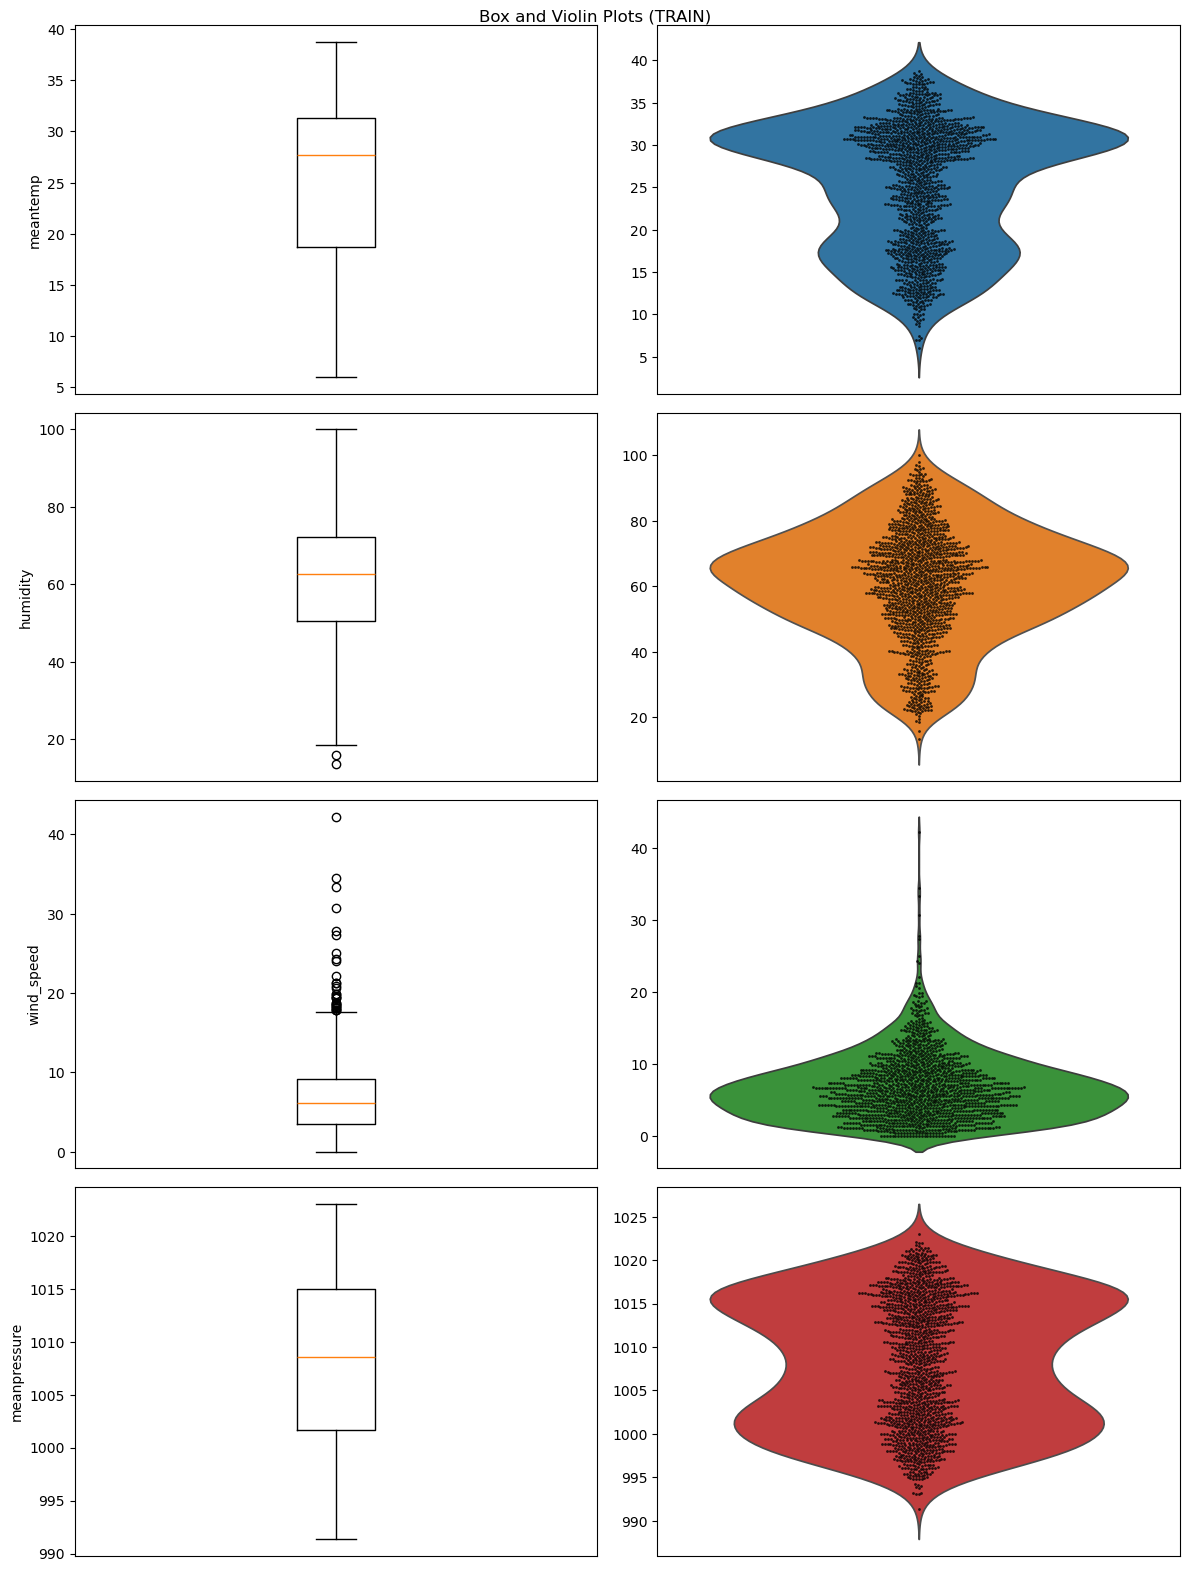

In [6]:
# with these corrections, check distributions again
fig, axs = plt.subplots(4,2, figsize=(12,16))
axs[0,0].boxplot(df['meantemp'].values)
axs[0,0].set_ylabel('meantemp')
axs[0,0].set_xticks([])
sns.violinplot(x = 1, y=df['meantemp'].values, inner=None, ax=axs[0,1], color='C0')
sns.swarmplot(x= 1, y=df['meantemp'].values, color='k', alpha=0.8, size=2, ax=axs[0,1])
axs[0,1].set_xticks([])


axs[1,0].boxplot(df['humidity'].values)
axs[1,0].set_ylabel('humidity')
axs[1,0].set_xticks([])
sns.violinplot(x = 1, y=df['humidity'].values, inner=None, ax=axs[1,1], color='C1')
sns.swarmplot(x= 1, y=df['humidity'].values, color='k', alpha=0.8, size=2, ax=axs[1,1])
axs[1,1].set_xticks([])


axs[2,0].boxplot(df['wind_speed'].values)
axs[2,0].set_ylabel('wind_speed')
axs[2,0].set_xticks([])
sns.violinplot(x = 1, y=df['wind_speed'].values, inner=None, ax=axs[2,1], color='C2')
sns.swarmplot(x= 1, y=df['wind_speed'].values, color='k', alpha=0.8, size=2, ax=axs[2,1])
axs[2,1].set_xticks([])

axs[3,0].boxplot(df['meanpressure'].values)
axs[3,0].set_ylabel('meanpressure')
axs[3,0].set_xticks([])
sns.violinplot(x = 1, y=df['meanpressure'].values, inner=None, ax=axs[3,1], color='C3')
sns.swarmplot(x= 1, y=df['meanpressure'].values, color='k', alpha=0.8, size=2, ax=axs[3,1])
axs[3,1].set_xticks([])

plt.suptitle('Box and Violin Plots (TRAIN)')
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, 2017-01-02 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      113 non-null    float64
 1   humidity      113 non-null    float64
 2   wind_speed    113 non-null    float64
 3   meanpressure  113 non-null    float64
dtypes: float64(4)
memory usage: 4.4+ KB


Negative meantemps: False
Negative humidity: False
Humidity > 100%: False
Negative wind_speed: False
Negative meanpressure: False


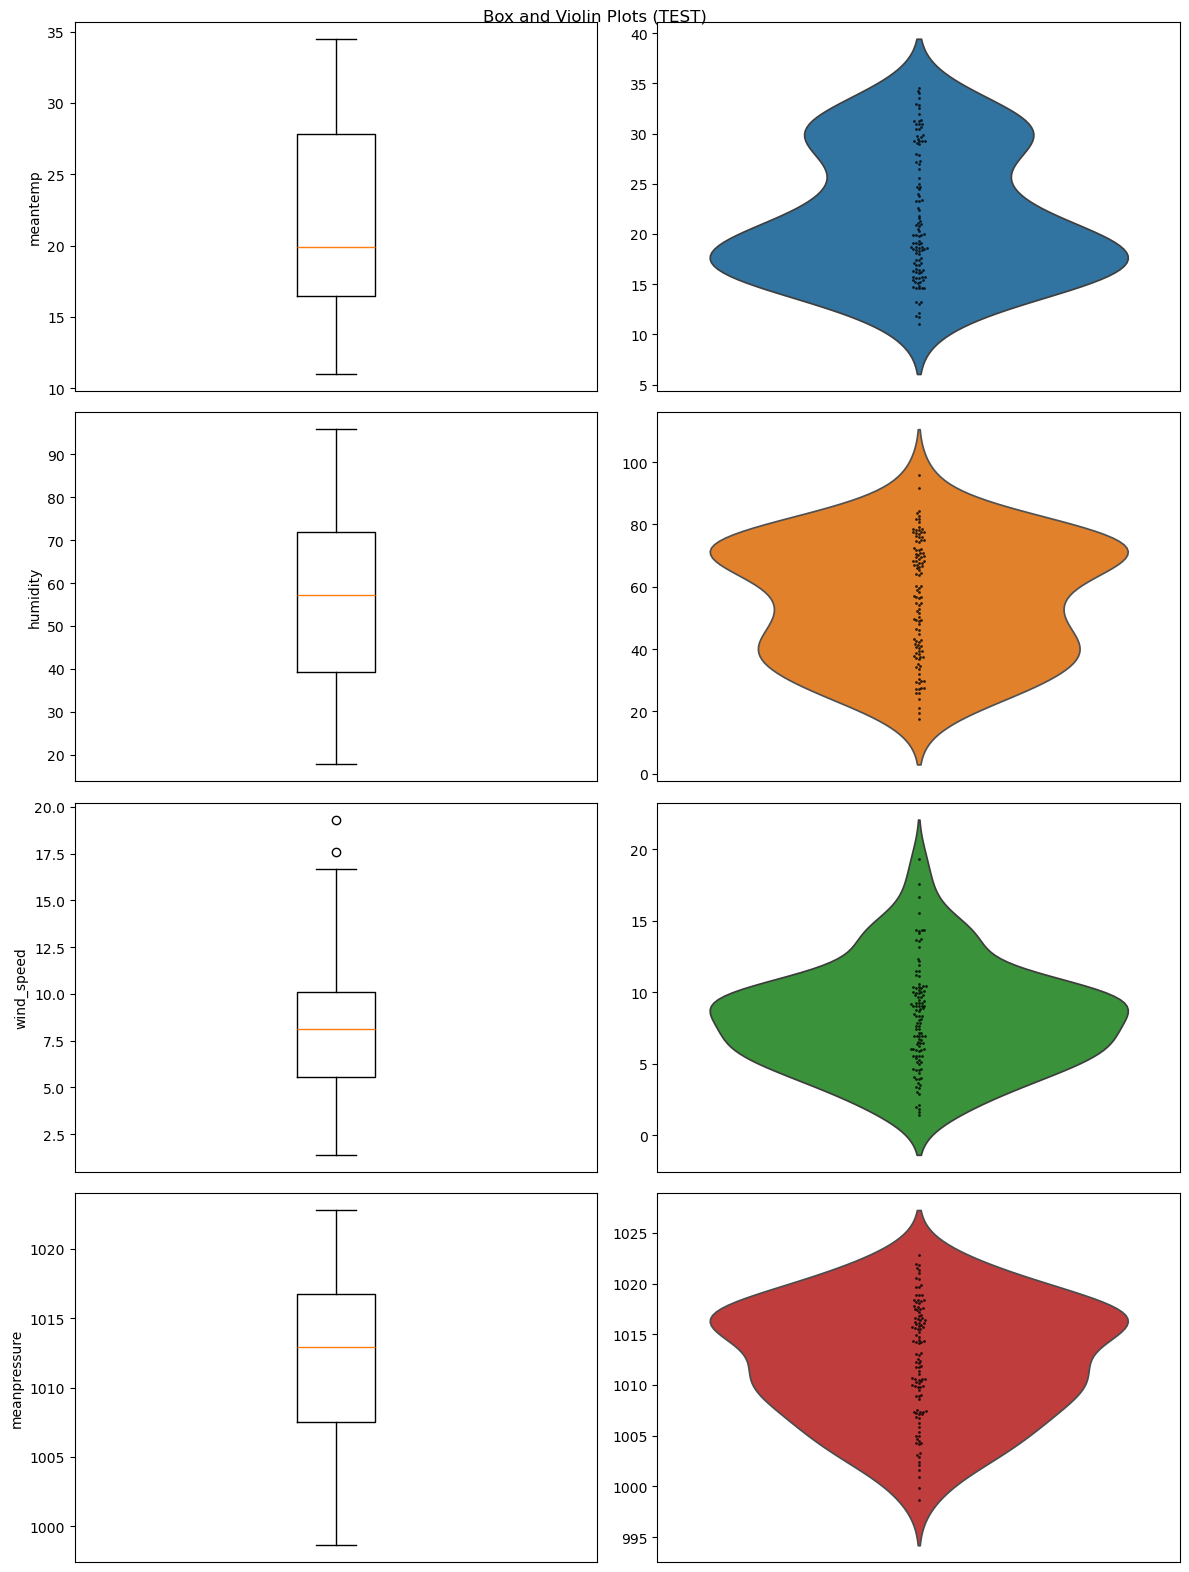

In [7]:
# Training/Val data look good. 
# Repeat for testing data
# load
df_test = pd.read_csv('DailyDelhiClimateTest.csv', index_col=0)
df_test = df_test[(df_test['meanpressure'] > 950) & (df_test['meanpressure'] < 1050)]

# check for null-entries
df_test.info()

# check for negative values and humidities > 100%
print('\n')
print(f'Negative meantemps: {(df_test['meantemp']<0).sum().astype(int) != 0}')
print(f'Negative humidity: {(df_test['humidity']<0).sum().astype(int) != 0}')
print(f'Humidity > 100%: {(df_test['humidity']>100).sum().astype(int) != 0}')
print(f'Negative wind_speed: {(df_test['wind_speed']<0).sum().astype(int) != 0}')
print(f'Negative meanpressure: {(df_test['meanpressure']<0).sum().astype(int) != 0}')

fig, axs = plt.subplots(4,2, figsize=(12,16))
axs[0,0].boxplot(df_test['meantemp'].values)
axs[0,0].set_ylabel('meantemp')
axs[0,0].set_xticks([])
sns.violinplot(x = 1, y=df_test['meantemp'].values, inner=None, ax=axs[0,1], color='C0')
sns.swarmplot(x= 1, y=df_test['meantemp'].values, color='k', alpha=0.8, size=2, ax=axs[0,1])
axs[0,1].set_xticks([])


axs[1,0].boxplot(df_test['humidity'].values)
axs[1,0].set_ylabel('humidity')
axs[1,0].set_xticks([])
sns.violinplot(x = 1, y=df_test['humidity'].values, inner=None, ax=axs[1,1], color='C1')
sns.swarmplot(x= 1, y=df_test['humidity'].values, color='k', alpha=0.8, size=2, ax=axs[1,1])
axs[1,1].set_xticks([])


axs[2,0].boxplot(df_test['wind_speed'].values)
axs[2,0].set_ylabel('wind_speed')
axs[2,0].set_xticks([])
sns.violinplot(x = 1, y=df_test['wind_speed'].values, inner=None, ax=axs[2,1], color='C2')
sns.swarmplot(x= 1, y=df_test['wind_speed'].values, color='k', alpha=0.8, size=2, ax=axs[2,1])
axs[2,1].set_xticks([])

axs[3,0].boxplot(df_test['meanpressure'].values)
axs[3,0].set_ylabel('meanpressure')
axs[3,0].set_xticks([])
sns.violinplot(x = 1, y=df_test['meanpressure'].values, inner=None, ax=axs[3,1], color='C3')
sns.swarmplot(x= 1, y=df_test['meanpressure'].values, color='k', alpha=0.8, size=2, ax=axs[3,1])
axs[3,1].set_xticks([])

plt.suptitle('Box and Violin Plots (TEST)')
plt.tight_layout()
plt.show()

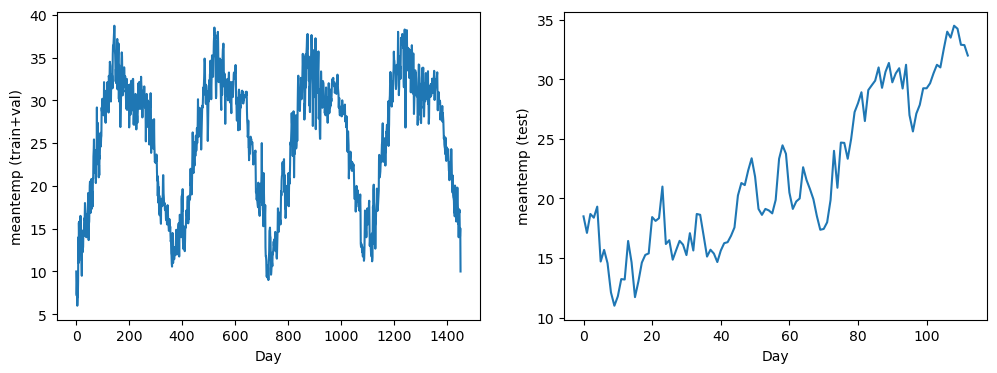

In [8]:
# lets look at our time series data for temp to see if there are any substantial gaps in data
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(df['meantemp'].values)
axs[0].set_ylabel('meantemp (train+val)')
axs[0].set_xlabel('Day')

axs[1].plot(df_test['meantemp'].values)
axs[1].set_ylabel('meantemp (test)')
axs[1].set_xlabel('Day')
plt.show()

In [9]:
# testing and training data are cleaned and there are no significant gaps in data

# standardize data
training_means = df.mean()
training_stds = df.std()
df = (df - training_means) / training_stds
df_test = (df_test - training_means) / training_stds

# create training and validation set
df_train = df[:int(0.8 * len(df))]
df_val = df[int(0.8 * len(df)):]

In [10]:
# function to generate lstm inputs and labels for a given window size
# labels are the next day's temperature, following a sequence of features
def generate_sequences(df_i, window):
    y = (df_i['meantemp'][window:]).to_numpy()
    x = []
    for i in range(len(df_i) - window): 
        x.append(df_i.iloc[i:i+window].values)
    x = np.array(x)
    return x, y

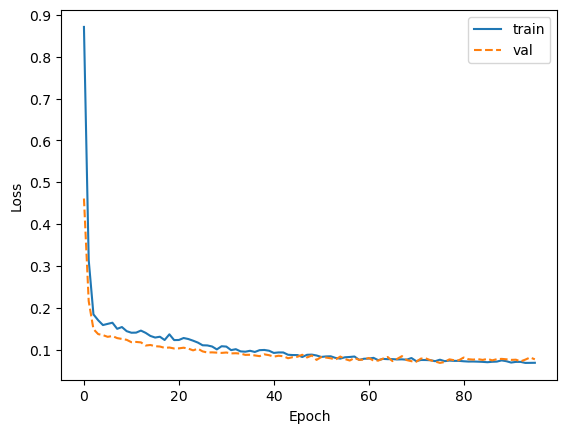

In [11]:
# generate input data and labels for a given window size 
window_size = 10
X_train, y_train = generate_sequences(df_train, window=window_size)
X_val, y_val = generate_sequences(df_val, window=window_size)
X_test, y_test = generate_sequences(df_test, window=window_size)

# build LSTM model
model = Sequential()
model.add(Input((window_size, 4)))
model.add(LSTM(32, 
    return_sequences=False, 
    kernel_regularizer=tf.keras.regularizers.l2(0.001), 
    recurrent_regularizer=tf.keras.regularizers.l2(0.001), 
    dropout=0.1,
    recurrent_dropout=0.1))
# linear activation for output since temperature is continous and unbounded
model.add(Dense(1, activation='linear'))

# use early stopping to prevent overfitting on training set
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.compile(loss=mse, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004))

# train
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),verbose=0, epochs=2000, callbacks=[early_stop])

# monitor loss and val loss during training
plt.plot(history.history['loss'], color='C0', label = 'train')
plt.plot(history.history['val_loss'], linestyle= 'dashed',color='C1', label = 'val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

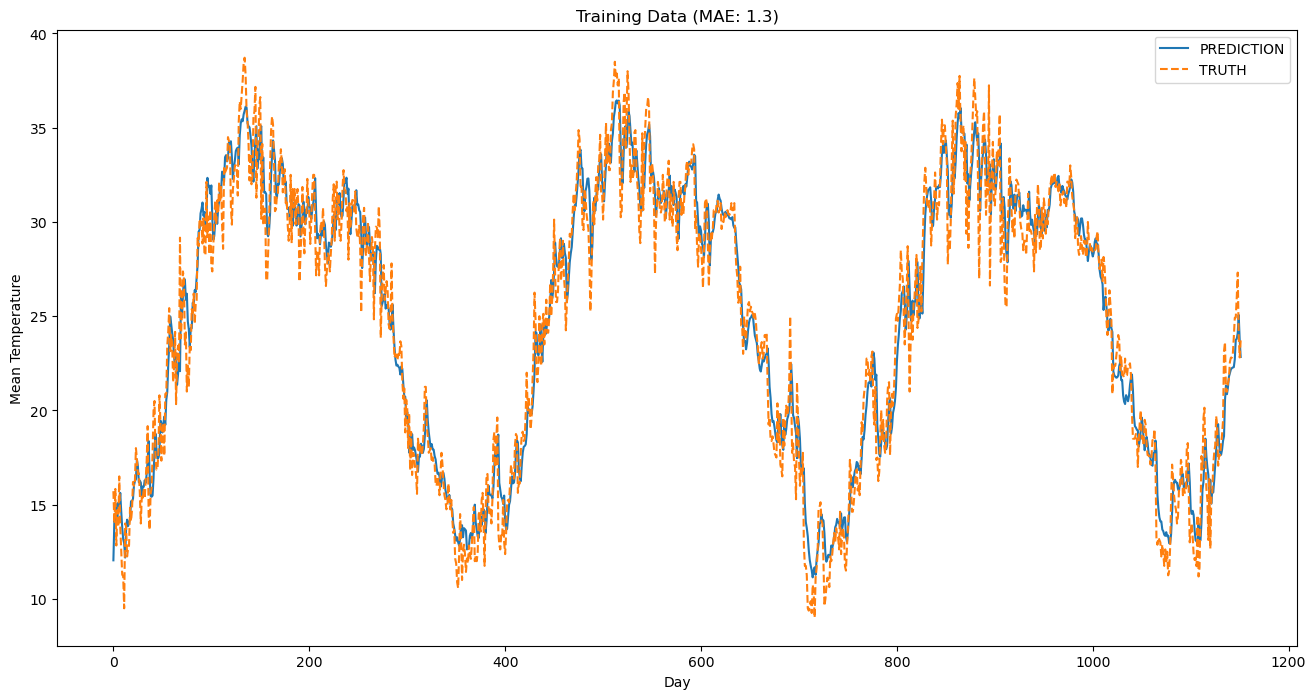

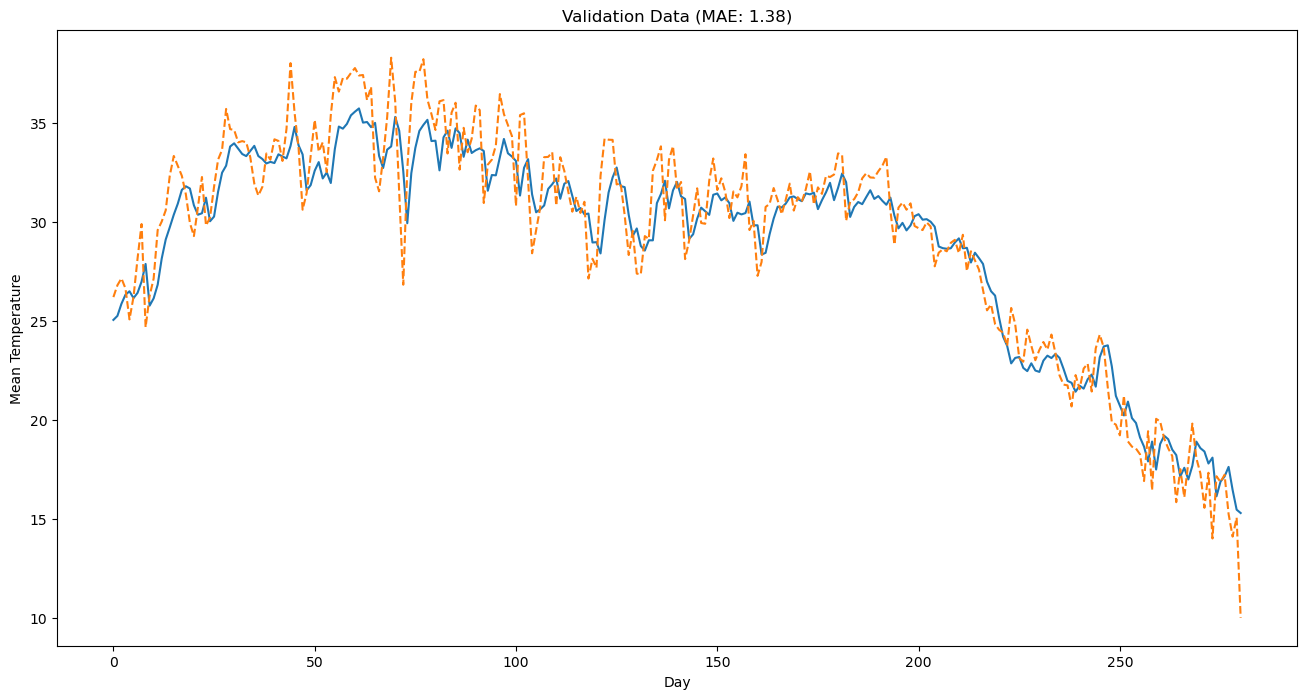

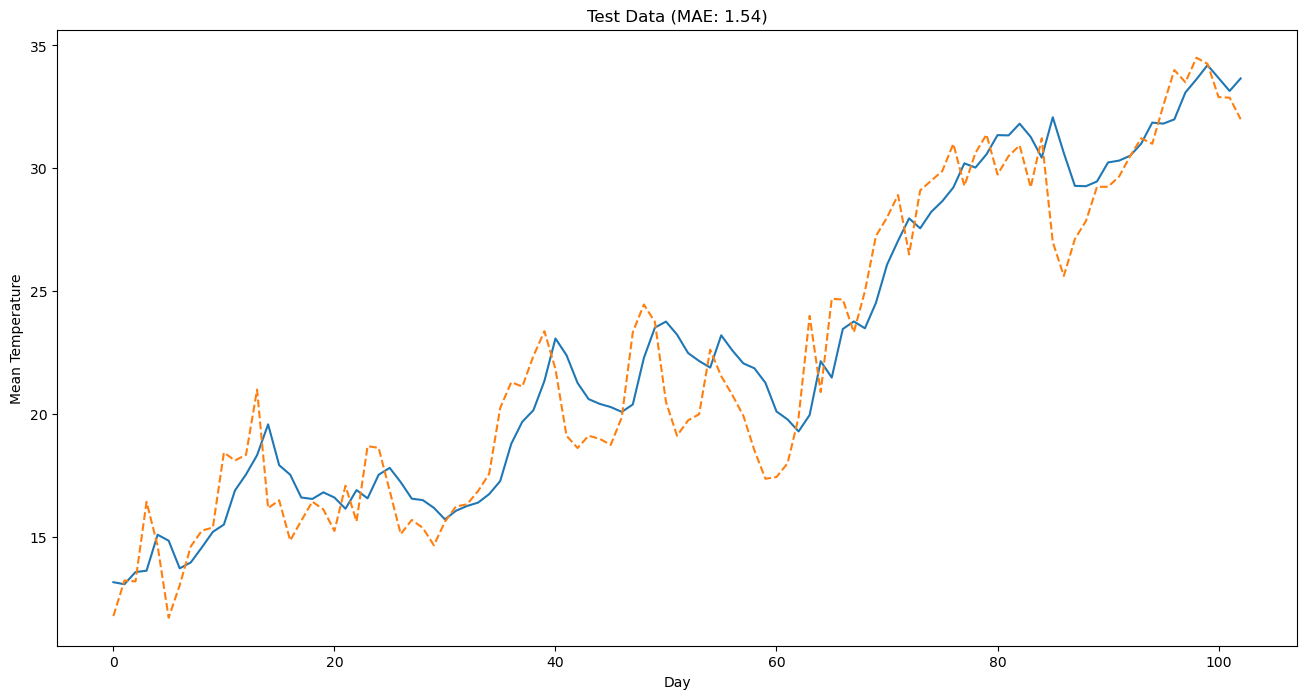

In [12]:
training_predictions = model.predict(X_train, verbose=0).reshape(-1)
# transform back to temperature
training_temp_predictions = training_predictions * training_stds['meantemp'] + training_means['meantemp']
training_temp_truth = y_train * training_stds['meantemp'] + training_means['meantemp']
plt.figure(figsize=(16,8))
plt.plot(training_temp_predictions, label='PREDICTION')
plt.plot(training_temp_truth, linestyle='dashed', label='TRUTH')
plt.ylabel('Mean Temperature')
plt.xlabel('Day')
plt.title(f'Training Data (MAE: {round(np.mean(abs(training_temp_predictions - training_temp_truth)),2)})')
plt.legend()
plt.show()

val_predictions = model.predict(X_val, verbose=0).reshape(-1)
val_temp_predictions = val_predictions * training_stds['meantemp'] + training_means['meantemp']
val_temp_truth = y_val * training_stds['meantemp'] + training_means['meantemp']
plt.figure(figsize=(16,8))
plt.plot(val_temp_predictions)
plt.plot(val_temp_truth, linestyle='dashed')
plt.ylabel('Mean Temperature')
plt.xlabel('Day')
plt.title(f'Validation Data (MAE: {round(np.mean(abs(val_temp_predictions - val_temp_truth)),2)})')
plt.show()

test_predictions = model.predict(X_test, verbose=0).reshape(-1)
test_temp_predictions = test_predictions * training_stds['meantemp'] + training_means['meantemp']
test_temp_truth = y_test * training_stds['meantemp'] + training_means['meantemp']
plt.figure(figsize=(16,8))
plt.plot(test_temp_predictions)
plt.plot(test_temp_truth, linestyle='dashed')
plt.ylabel('Mean Temperature')
plt.xlabel('Day')
plt.title(f'Test Data (MAE: {round(np.mean(abs(test_temp_predictions - test_temp_truth)),2)})')
plt.show()